In [1]:
import numpy as np
import pandas as pd
import os
import nltk
import scipy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [2]:
cwd = os.getcwd()

# Convert the data into Python dataframe.
finance_dataset = pd.read_csv(f"{cwd}/labelled_news.csv")

# total number of rows, each attribute type and number of non null values
finance_dataset.info()

# How many categories exists and how much data belong to each category
finance_dataset['Label'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4176 entries, 0 to 4175
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  4176 non-null   int64  
 1   Date        4176 non-null   object 
 2   Summary     4176 non-null   object 
 3   Label       4176 non-null   float64
 4   Close       4176 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 163.2+ KB


1.0    2208
0.0    1968
Name: Label, dtype: int64

In [3]:
def clean_data(data):
    #removes the rows that contains NULL values and inplace modifies the original datset instead of creating anew one
    summarised_data = data
    summarised_data.dropna(inplace=True)
    #Change all the text to lower case. This is required as python interprets lowercase and uppercase differently
    summarised_data = [entry.lower() for entry in summarised_data]
    #Tokenization : In this each entry in the corpus will be broken into set of words
    summarised_data = [word_tokenize(entry) for entry in summarised_data]
    #Remove stopwords
    english_stop_words=set(stopwords.words("english"))
    summarised_data=list(map(lambda l: list(filter(lambda summarised_data: summarised_data not in english_stop_words, l)), summarised_data))
    # Lemmatisation. This is required to convert the word into root form
    wordnet_lemmatizer = WordNetLemmatizer()
    summarised_data=list(map(lambda l: list(filter(lambda summarised_data: summarised_data in wordnet_lemmatizer.lemmatize(summarised_data), l)), summarised_data))
    summarised_words_list = summarised_data
    # convert list to string
    summarised_data = [' '.join(map(str, l)) for l in summarised_data]
    return summarised_data, summarised_words_list

In [4]:
summarised_data, summarised_words_list = clean_data(finance_dataset['Summary'])
finance_dataset['preprocessed_text'] = summarised_data
finance_dataset['preprocessed_words_list'] = summarised_words_list
finance_dataset.info()
finance_dataset['Label'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4176 entries, 0 to 4175
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               4176 non-null   int64  
 1   Date                     4176 non-null   object 
 2   Summary                  4176 non-null   object 
 3   Label                    4176 non-null   float64
 4   Close                    4176 non-null   float64
 5   preprocessed_text        4176 non-null   object 
 6   preprocessed_words_list  4176 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 228.5+ KB


1.0    2208
0.0    1968
Name: Label, dtype: int64

<AxesSubplot:>

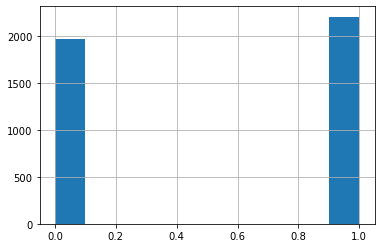

In [5]:
finance_dataset['Label'].hist()

In [6]:
train, test = train_test_split(finance_dataset, test_size=0.2, random_state=7)

# train = finance_dataset[finance_dataset['Date'] < '20180101']
# test = finance_dataset[finance_dataset['Date'] > '20171231']
x_train=train['preprocessed_text']
y_train = train['Label']
x_test=test['preprocessed_text']
y_test = test['Label']
print('X train size = ' , x_train.shape)
print('Y train size = ' , y_train.shape)
print('X test size = ' , x_test.shape)
print('Y test size = ' , y_test.shape)

X train size =  (3340,)
Y train size =  (3340,)
X test size =  (836,)
Y test size =  (836,)


In [7]:
## Tf-Idf
finance_vectorizer = TfidfVectorizer(min_df=2, max_df=0.80, 
                              sublinear_tf=True, use_idf =True,       
                              ngram_range = (1,3),
                              stop_words = "english")


x_train_tfidf = finance_vectorizer.fit_transform(x_train)
x_test_tfidf = finance_vectorizer.transform(x_test)

In [8]:
# Baseline Random forest based Model
lgc = LogisticRegression()
lgc_model = lgc.fit(x_train_tfidf,y_train) # fit on training data


####### Prediction ##########
predictions = lgc_model.predict(x_test_tfidf)
print(' Accuracy: ', round(accuracy_score(y_test, predictions)*100, 2))
print('\n Classification Report:\n', classification_report(y_test,predictions))

 Accuracy:  52.39

 Classification Report:
               precision    recall  f1-score   support

         0.0       0.47      0.36      0.41       380
         1.0       0.55      0.66      0.60       456

    accuracy                           0.52       836
   macro avg       0.51      0.51      0.51       836
weighted avg       0.52      0.52      0.51       836

